In [ ]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])
class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [ ]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)   #reward for bad state changed to -100
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [ ]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [ ]:
env.P[0,:,0]

array([0.85, 0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [ ]:
# initialize Q
Q = np.zeros((env.num_states, env.num_actions))


In [ ]:
from scipy.special import softmax as sf

seed = 42
rg = np.random.RandomState(seed)

def epsilon_greedy(Q,epsilon,state,rg= rg): #state -> form of number
  max_q_value_action = np.argmax(Q[state])
  num_actions = len(Q[state])
  probab = [epsilon/num_actions if i!= max_q_value_action else 1-epsilon+(epsilon/num_actions) for i in range(num_actions)]
  action_returned_epgreedy = np.random.choice(np.arange(num_actions),1, p = probab)[0]
  return action_returned_epgreedy

def softmax(Q,beta, state,rg = rg):

  probab_softmax = sf(Q[state]/beta)
  num_actions = len(Q[state])
  action_returned_softmax = np.random.choice(np.arange(num_actions),1, p = probab_softmax)[0]
  return action_returned_softmax

In [ ]:
def QLearn(env, Q, gamma = 0.9, alpha=0.4,num_episodes = 1000, action_taken = epsilon_greedy,epsilon = 0.1,beta = 1):

  reward_each_episode = np.zeros(num_episodes)
  steps_each_episode = np.zeros(num_episodes)
  num_times_state_visites_per_episode  = np.zeros([num_episodes,env.num_states])
  num_states = (env.num_states)

  for i in range(num_episodes):
    curr_e = (0.99**i)*epsilon
    eps = curr_e if curr_e >0.05 else 0.05

    initial_state = env.reset()
    terminal_states = env.goal_states
    curr_state = initial_state
    num_times_state_visites_per_episode[i,curr_state] +=1
    curr_action = action_taken(Q,eps,curr_state) if action_taken == epsilon_greedy else action_taken(Q, beta, curr_state)
    time_step = 1 
    reward_ = 0

    while ((np.all(np.sum(abs(terminal_states - seq_to_col_row(curr_state,env.num_cols)), 1))) and (time_step<=100)):
      next_state,reward = env.step(curr_state,curr_action)
      action_in_next_state = action_taken(Q,eps,next_state) if action_taken == epsilon_greedy else action_taken(Q, beta, next_state) 
      Q[curr_state,curr_action] += alpha*(reward + (gamma*max(Q[next_state])) - Q[curr_state,curr_action])
      curr_state,curr_action = next_state,action_in_next_state
      num_times_state_visites_per_episode[i,curr_state] +=1
      time_step +=1
      reward_ += reward
    
    reward_each_episode[i] = reward_
    steps_each_episode[i]  = time_step

  return Q,reward_each_episode,steps_each_episode,num_times_state_visites_per_episode.sum(axis = 0)



In [ ]:
#Finding the optimal policy
#0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
def plot_Q(Q, message = "Q plot"):
    
    sns.heatmap(Q.max(-1), cbar = True,annot = True)
    #plt.colorbar()
    def x_direct(a):
        if a in [0,1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 0 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_state_visit_counts(num_times_state_visites,env):
  num_times_state_visites = num_times_state_visites.reshape((env.num_rows, env.num_cols))
  sns.heatmap(num_times_state_visites,annot = True,annot_kws={"size": 6})



In [ ]:
def run_simulation(Q,env,gamma,alpha,beta=1,epsilon=0.1,num_expts = 1, num_episodes = 1000,explore_strategy = epsilon_greedy):
  
  reward_avgs, steps_avgs,state_visit_count = [],[], []
  Q_avg = np.zeros(Q.shape)

  for i in range(num_expts):

      Q = np.zeros((env.num_states, env.num_actions))
      rg = np.random.RandomState(i)
      Q,reward_each_episode, steps_each_episode, num_times_state_visites = QLearn(env, Q, gamma =gamma, alpha=alpha,num_episodes = num_episodes, action_taken = explore_strategy,epsilon = epsilon,beta = beta)
      Q_avg += Q
      reward_avgs.append(reward_each_episode)
      steps_avgs.append(steps_each_episode)
      state_visit_count.append(num_times_state_visites)


  Q_avg               = Q_avg/num_expts
  reward_avgs         = np.array(reward_avgs).mean(axis = 0)
  steps_avgs          = np.array(steps_avgs).mean(axis = 0)
  state_visit_count   = np.array(state_visit_count).sum(axis = 0)

  return Q_avg,reward_avgs,steps_avgs,state_visit_count

In [ ]:
def cal_reward_Q(Q,env,repeat = 3):
  cumul_reward = 0
  for i in range(repeat):
    initial_state = env.reset()
    curr_state = initial_state
    time_step = 0
    while (np.all(np.sum(abs(env.goal_states - seq_to_col_row(curr_state,env.num_cols)), 1)) and time_step<100 ):
      curr_action = np.argmax(Q[curr_state])
      next_state, reward = env.step(curr_state,curr_action)
      cumul_reward += reward
      curr_state = next_state
      time_step +=1
  return (cumul_reward[0]/3)

 

In [ ]:
#plotting heatmaps and saving plots
import matplotlib.pyplot as plt
import seaborn as sns
config_num = 1
def plot_figures(obj,env,config_num):

  p,wind,start_state,explore_strategy = obj[0]
  env.p_good_trans = p
  env.wind = wind
  env.start_state = start_state
  Q = np.zeros((env.num_states, env.num_actions))  # included here as every time I run the code Q gets initialized
  num_episodes = 1000
  
  print('Probability of good transition: ',p, ' Wind: ',wind," Start state: ",start_state)
  if explore_strategy == epsilon_greedy:
    epsilon,gamma,alpha = obj[1],obj[2],obj[3]
    print('Explore strategy: epsilon_greedy, ','Best epsilon, gamma, alpha are :  ',epsilon,gamma,alpha)
    Q,reward_each_episode, steps_each_episode, num_times_state_visites = run_simulation(Q,env,gamma,alpha,epsilon,num_expts =3, num_episodes = num_episodes,explore_strategy = epsilon_greedy)
    plt.figure(figsize = (15,15))
    plt.subplot(2,2,1)
    plt.title("Reward vs episodes")
    plt.xlabel("Number of episodes")
    plt.ylabel("Reward per episode")
    plt.plot(np.arange(num_episodes),reward_each_episode)
    plt.subplot(2,2,2)
    plt.title("Steps taken vs episodes")
    plt.xlabel("Number of episodes")
    plt.ylabel("Steps taken per episode")
    plt.plot(np.arange(num_episodes),steps_each_episode)
    plt.subplot(2,2,3)
    plt.title("State visit counts vs episodes")
    plot_state_visit_counts(num_times_state_visites,env)
    plt.subplot(2,2,4)
    plt.title('Heatmap of Action-value function(Q(s,a))')
    plot_Q(Q.reshape((env.num_rows,env.num_cols,env.num_actions)))
    plt.savefig('config_QLearn'+str(config_num)+'.png', dpi = 500)
    plt.show()
  if explore_strategy == softmax:
    beta,gamma,alpha = obj[1],obj[2],obj[3]
    print('Explore strategy: softmax, ','Best beta, gamma, alpha are :  ',beta,gamma,alpha)
    Q,reward_each_episode, steps_each_episode, num_times_state_visites = run_simulation(Q,env,gamma,alpha,beta = beta,num_expts =3, num_episodes = num_episodes,explore_strategy = softmax)
    plt.figure(figsize = (15,15))
    plt.subplot(2,2,1)
    plt.title("Reward vs episodes")
    plt.xlabel("Number of episodes")
    plt.ylabel("Reward per episode")
    plt.plot(np.arange(num_episodes),reward_each_episode)
    plt.subplot(2,2,2)
    plt.title("Steps taken vs episodes")
    plt.xlabel("Number of episodes")
    plt.ylabel("Steps taken per episode")
    plt.plot(np.arange(num_episodes),steps_each_episode)
    plt.subplot(2,2,3)
    plt.title("State visit counts vs episodes")
    plot_state_visit_counts(num_times_state_visites,env)
    plt.subplot(2,2,4)
    plt.title('Heatmap of Action-value function(Q(s,a))')
    plot_Q(Q.reshape((env.num_rows,env.num_cols,env.num_actions)))
    plt.savefig('config_QLearn'+str(config_num)+'.png', dpi = 500)
    plt.show()
    config_num +=1


Current config:  1
Probability of good transition:  1  Wind:  True  Start state:  [[3, 6]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.5 0.9 0.5


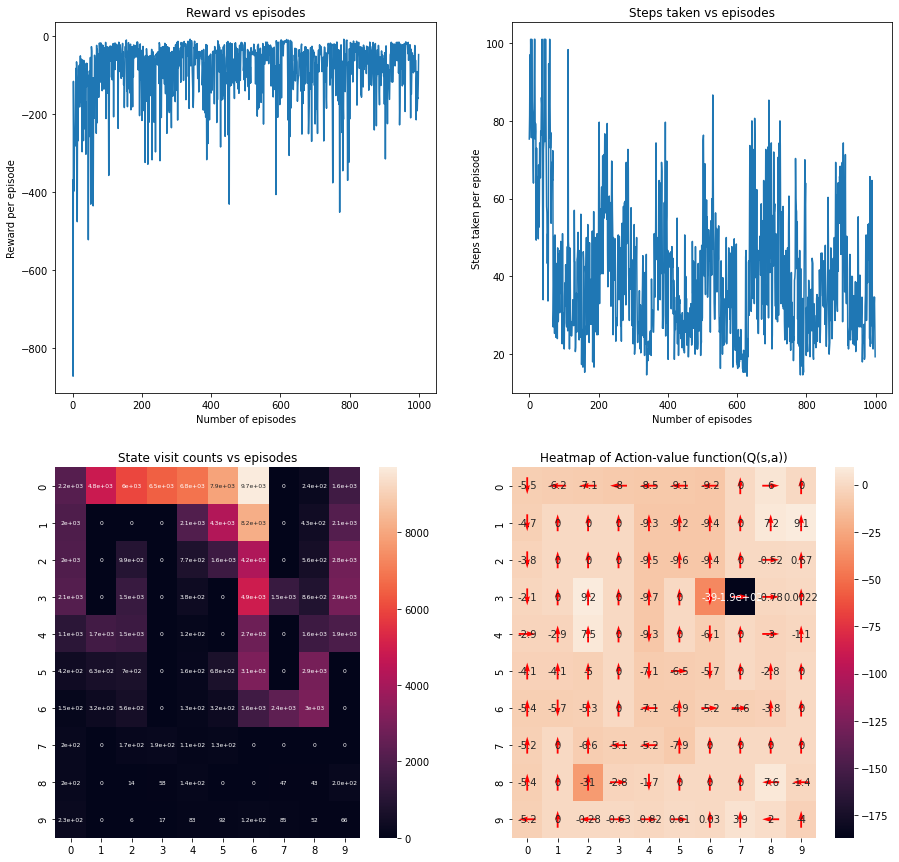

[[1, True, [[3, 6]], <function epsilon_greedy at 0x7f7e8c1b30d0>], 0.5, 0.9, 0.5, -11.333333333333334] -11.333333333333334
Current config:  2
Probability of good transition:  1  Wind:  True  Start state:  [[3, 6]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   0.1 0.9 0.9


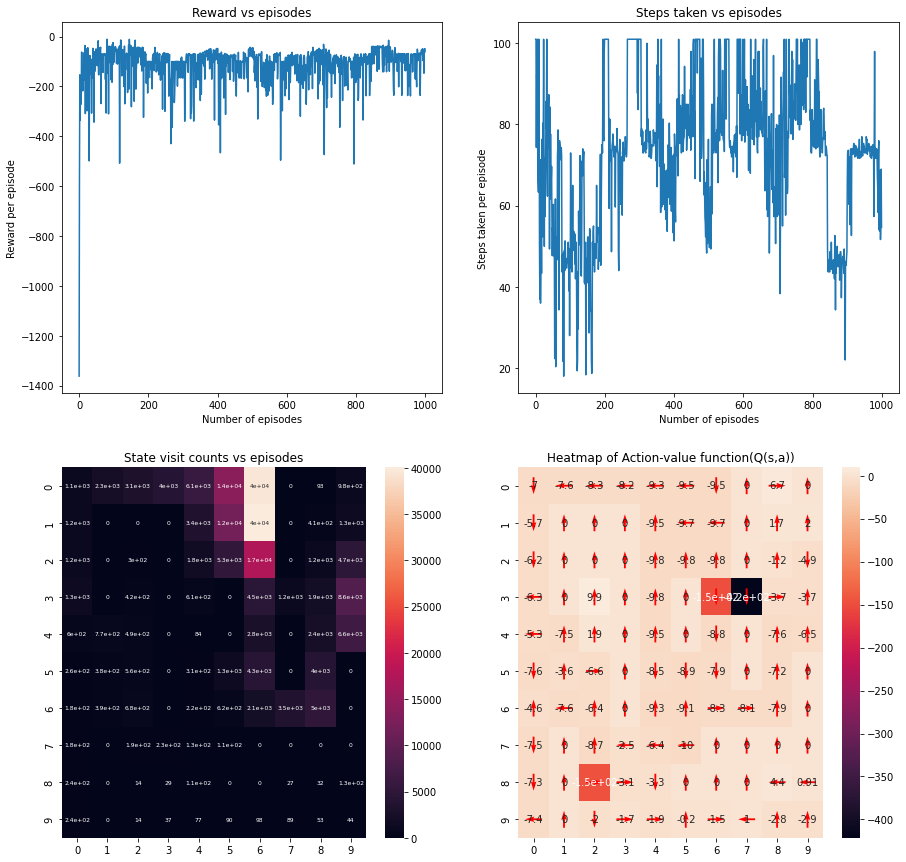

[[1, True, [[3, 6]], <function softmax at 0x7f7e8c1b3280>], 0.1, 0.9, 0.9, -9.333333333333334] -9.333333333333334
Current config:  3
Probability of good transition:  1  Wind:  True  Start state:  [[0, 4]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.5 0.9 0.5


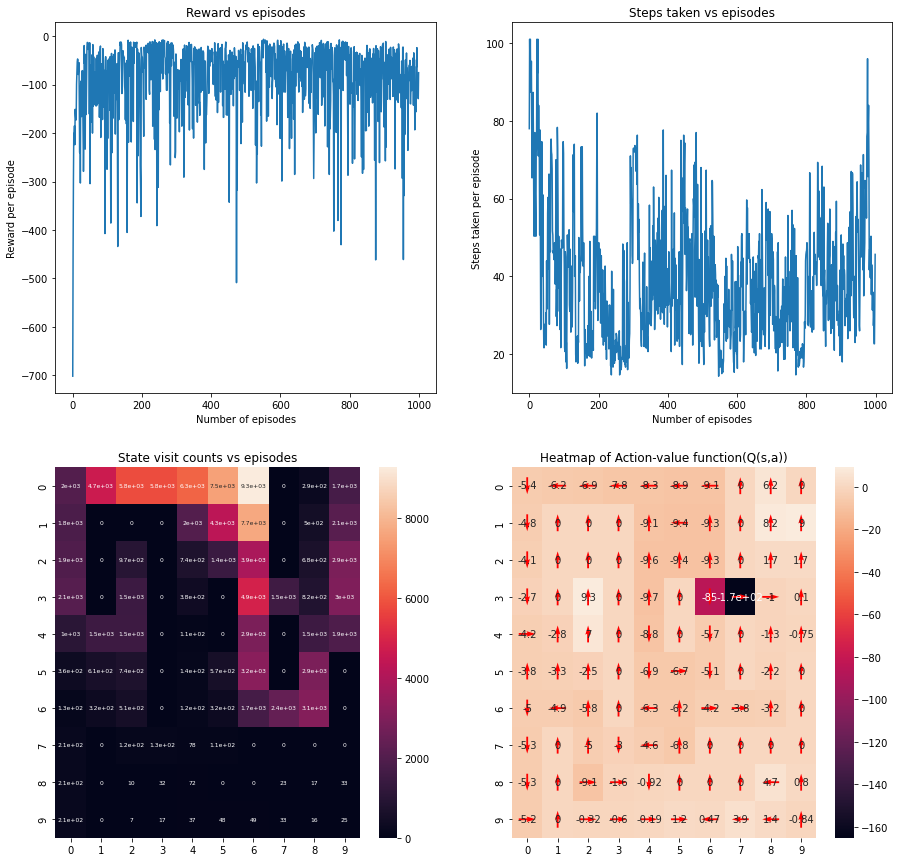

[[1, True, [[0, 4]], <function epsilon_greedy at 0x7f7e8c1b30d0>], 0.5, 0.9, 0.5, -8.666666666666666] -8.666666666666666
Current config:  4
Probability of good transition:  1  Wind:  True  Start state:  [[0, 4]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   0.1 0.9 0.1


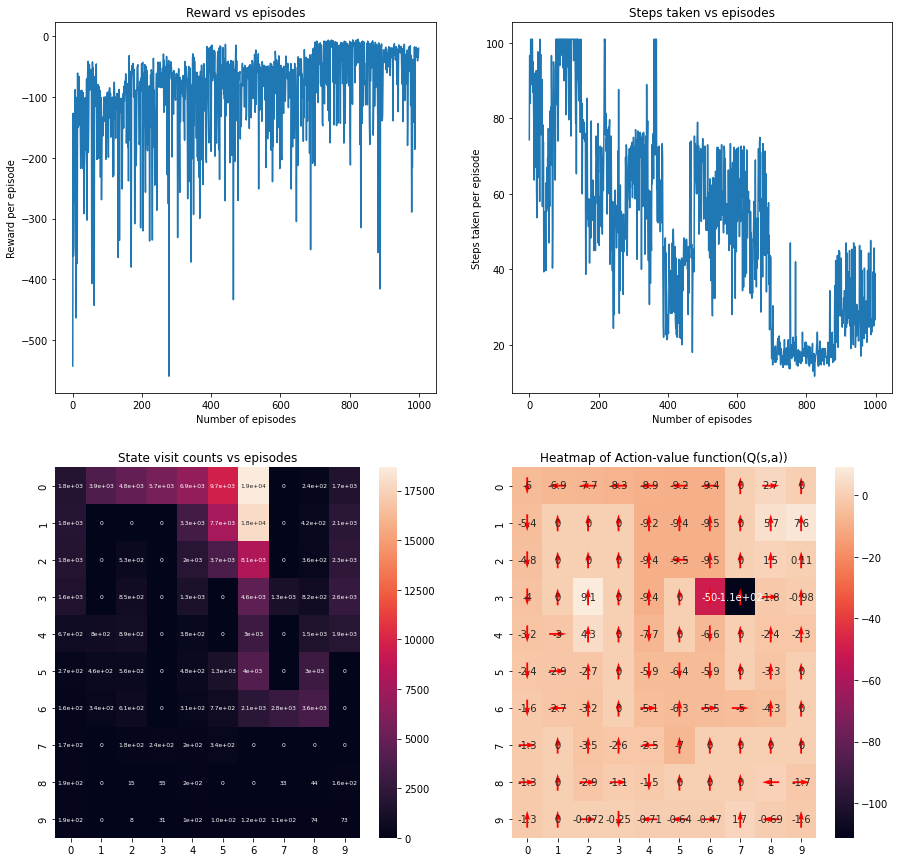

[[1, True, [[0, 4]], <function softmax at 0x7f7e8c1b3280>], 0.1, 0.9, 0.1, -8.0] -8.0
Current config:  5
Probability of good transition:  1  Wind:  False  Start state:  [[3, 6]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.1 0.1 0.1


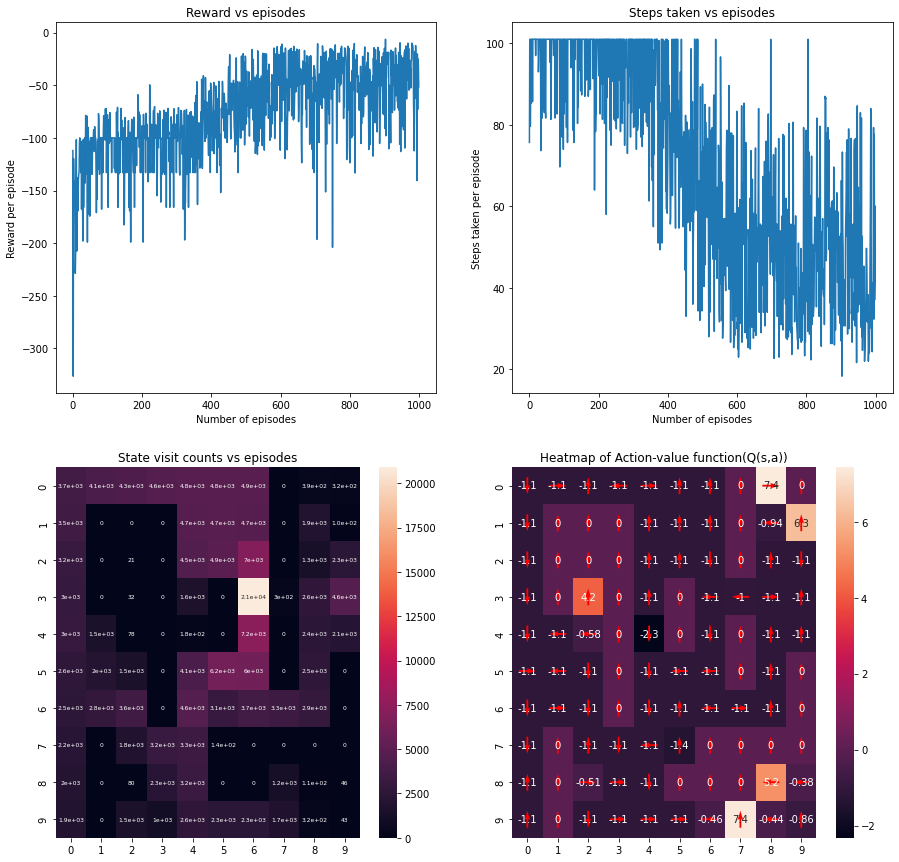

[[1, False, [[3, 6]], <function epsilon_greedy at 0x7f7e8c1b30d0>], 0.1, 0.1, 0.1, -9.666666666666666] -9.666666666666666
Current config:  6
Probability of good transition:  1  Wind:  False  Start state:  [[3, 6]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   1 0.5 0.1


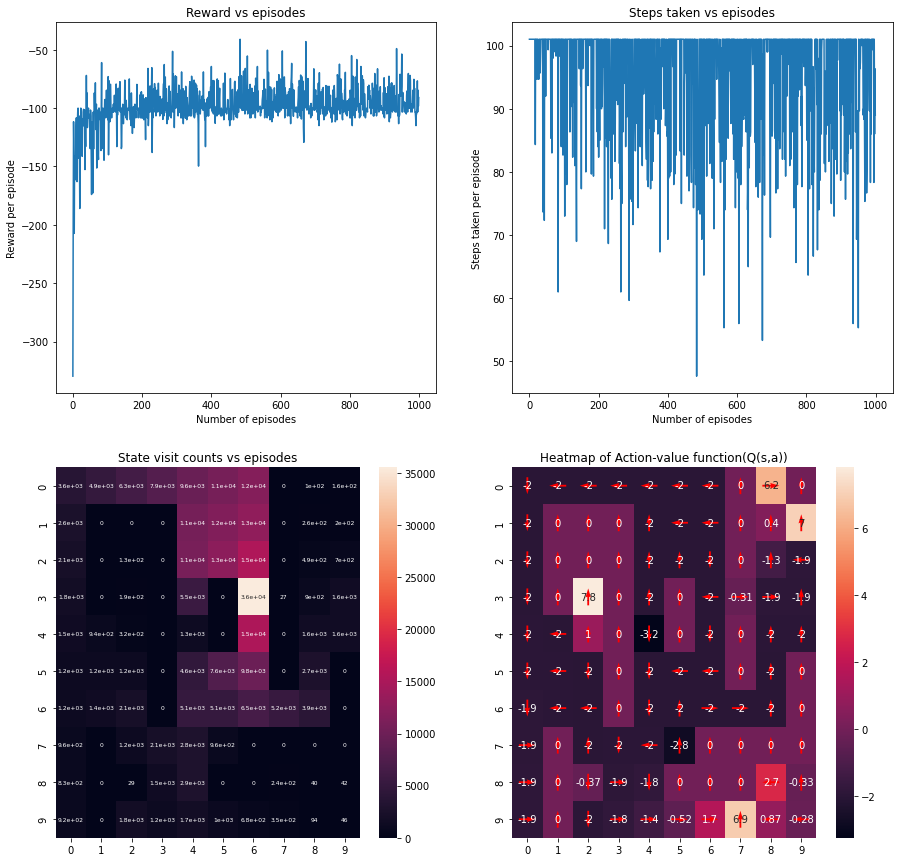

[[1, False, [[3, 6]], <function softmax at 0x7f7e8c1b3280>], 1, 0.5, 0.1, -6.666666666666667] -6.666666666666667
Current config:  7
Probability of good transition:  1  Wind:  False  Start state:  [[0, 4]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.5 0.9 0.5


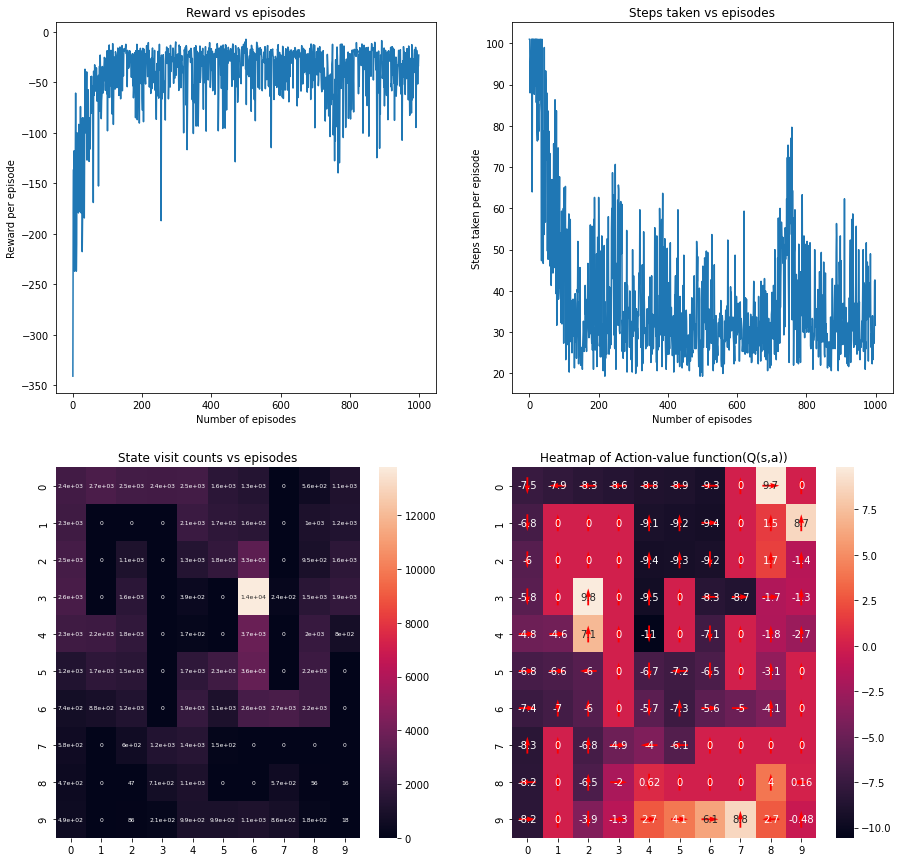

[[1, False, [[0, 4]], <function epsilon_greedy at 0x7f7e8c1b30d0>], 0.5, 0.9, 0.5, -11.0] -11.0
Current config:  8
Probability of good transition:  1  Wind:  False  Start state:  [[0, 4]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   10 0.9 0.9


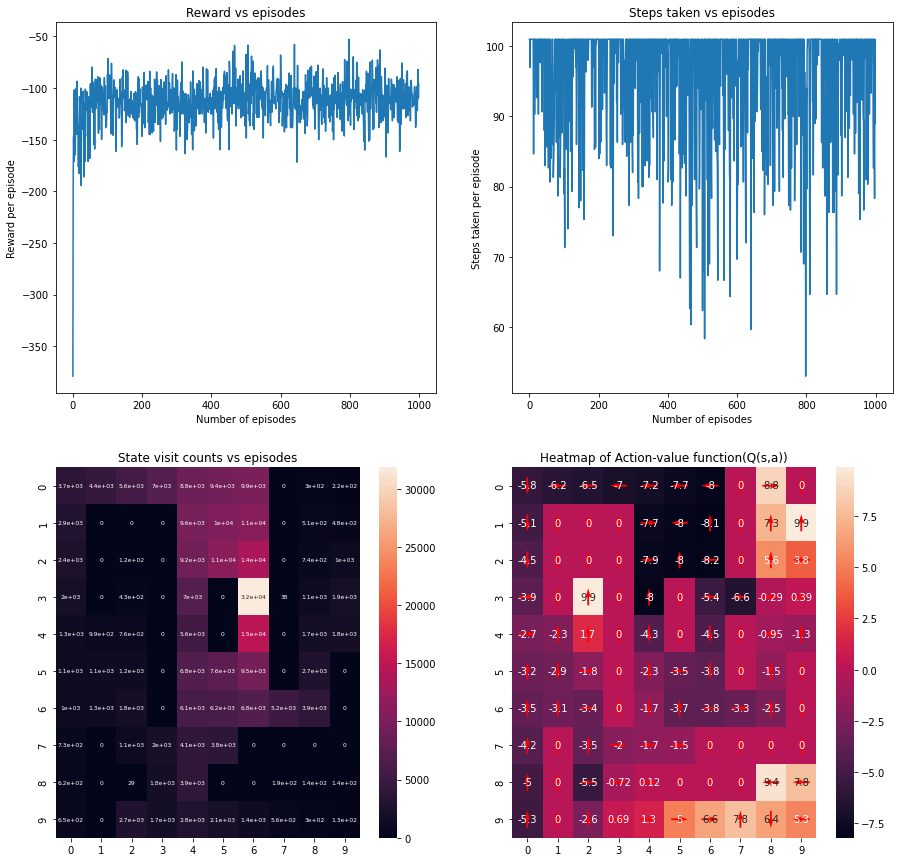

[[1, False, [[0, 4]], <function softmax at 0x7f7e8c1b3280>], 10, 0.9, 0.9, -10.0] -10.0
Current config:  9
Probability of good transition:  0.7  Wind:  True  Start state:  [[3, 6]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.9 0.9 0.1


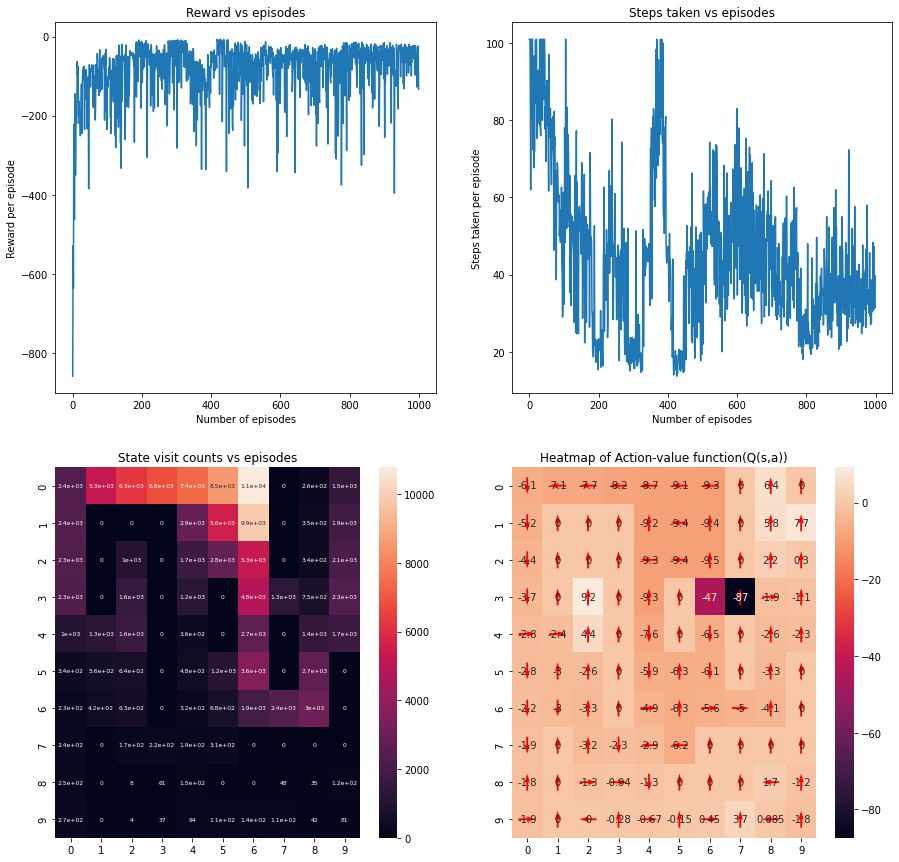

[[0.7, True, [[3, 6]], <function epsilon_greedy at 0x7f7e8c1b30d0>], 0.9, 0.9, 0.1, -9.666666666666666] -9.666666666666666
Current config:  10
Probability of good transition:  0.7  Wind:  True  Start state:  [[3, 6]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   1 0.9 0.1


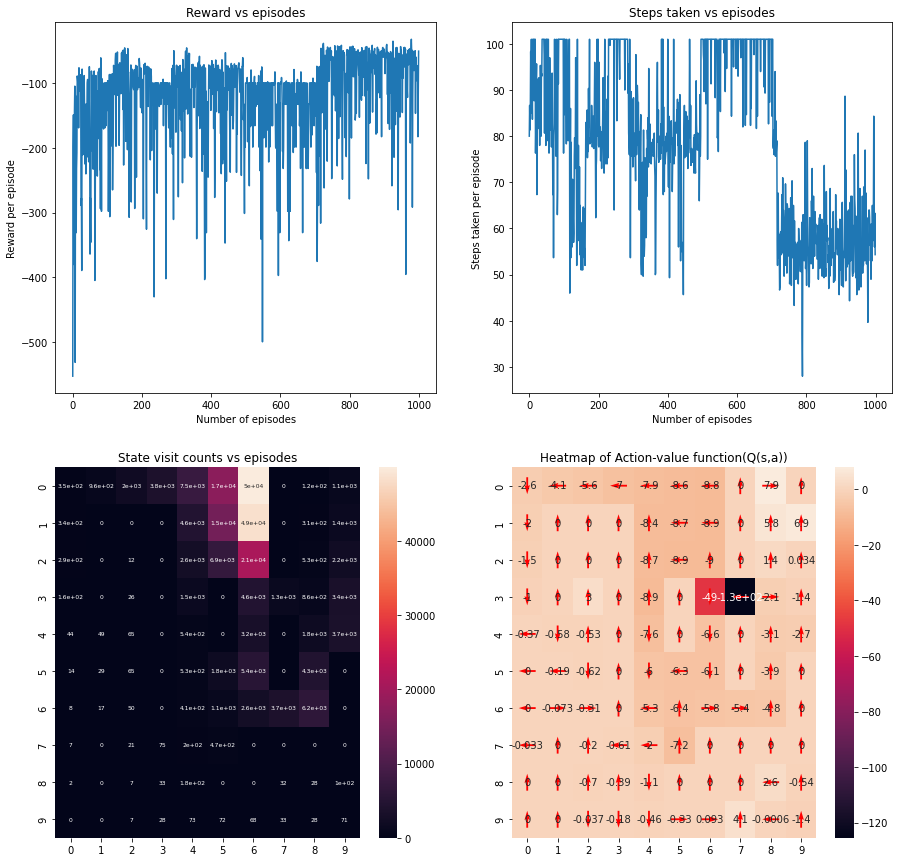

[[0.7, True, [[3, 6]], <function softmax at 0x7f7e8c1b3280>], 1, 0.9, 0.1, -6.333333333333333] -6.333333333333333
Current config:  11
Probability of good transition:  0.7  Wind:  True  Start state:  [[0, 4]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.5 0.9 0.5


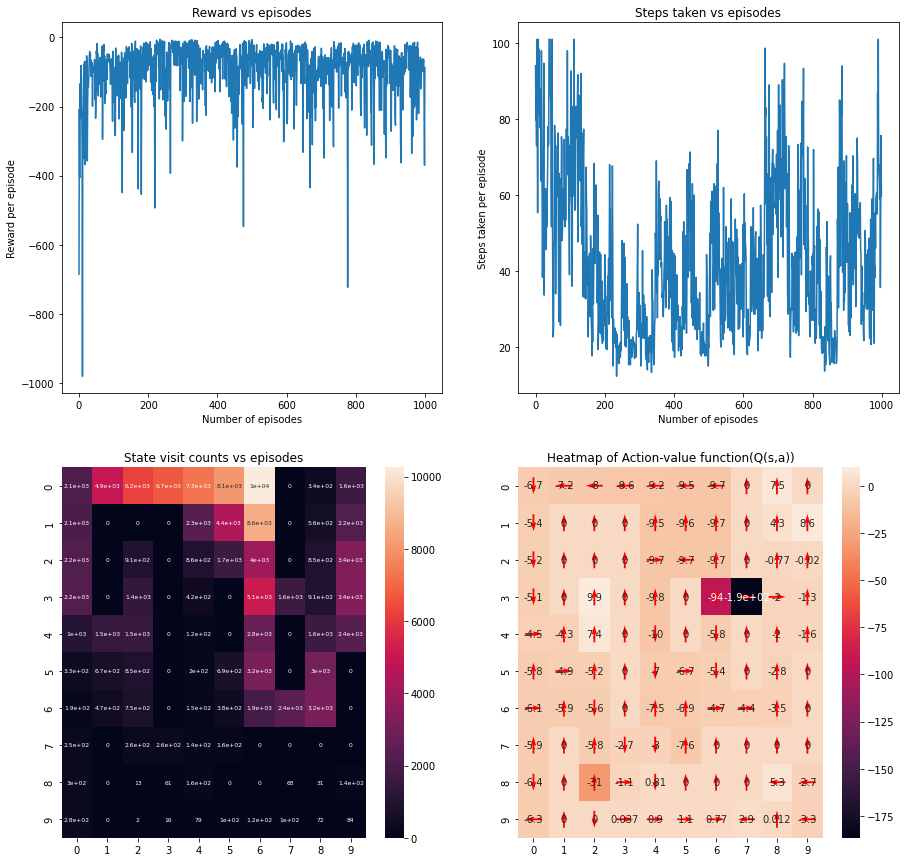

[[0.7, True, [[0, 4]], <function epsilon_greedy at 0x7f7e8c1b30d0>], 0.5, 0.9, 0.5, -7.666666666666667] -7.666666666666667
Current config:  12
Probability of good transition:  0.7  Wind:  True  Start state:  [[0, 4]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   1 0.9 0.5


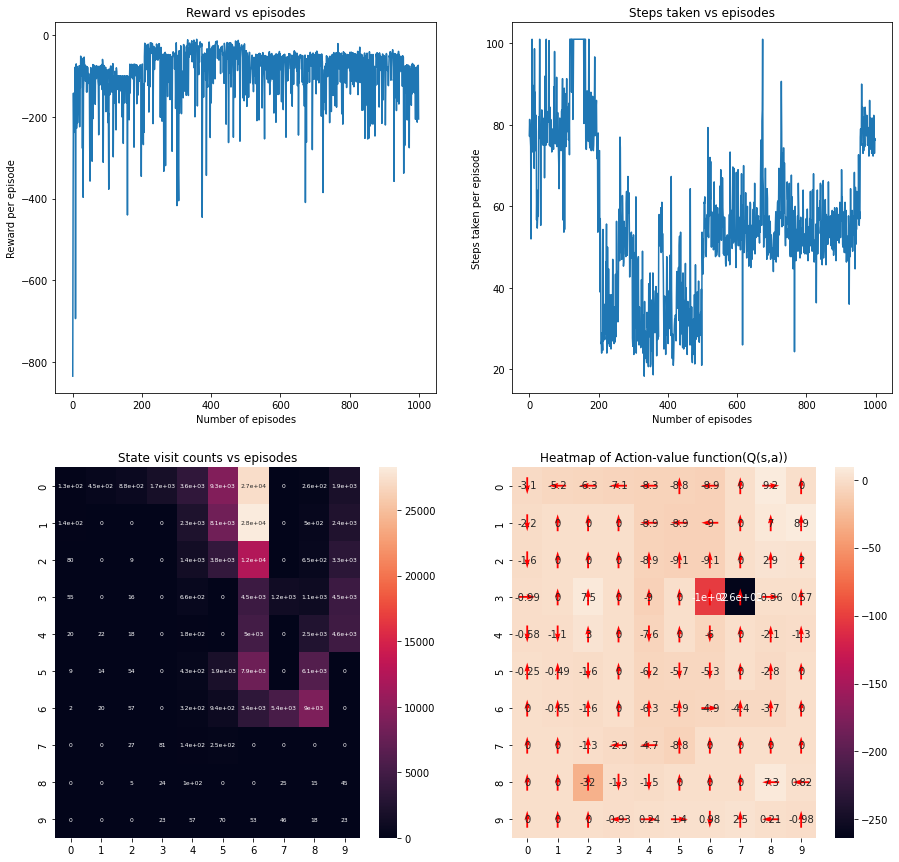

[[0.7, True, [[0, 4]], <function softmax at 0x7f7e8c1b3280>], 1, 0.9, 0.5, -7.0] -7.0
Current config:  13
Probability of good transition:  0.7  Wind:  False  Start state:  [[3, 6]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.5 0.9 0.9


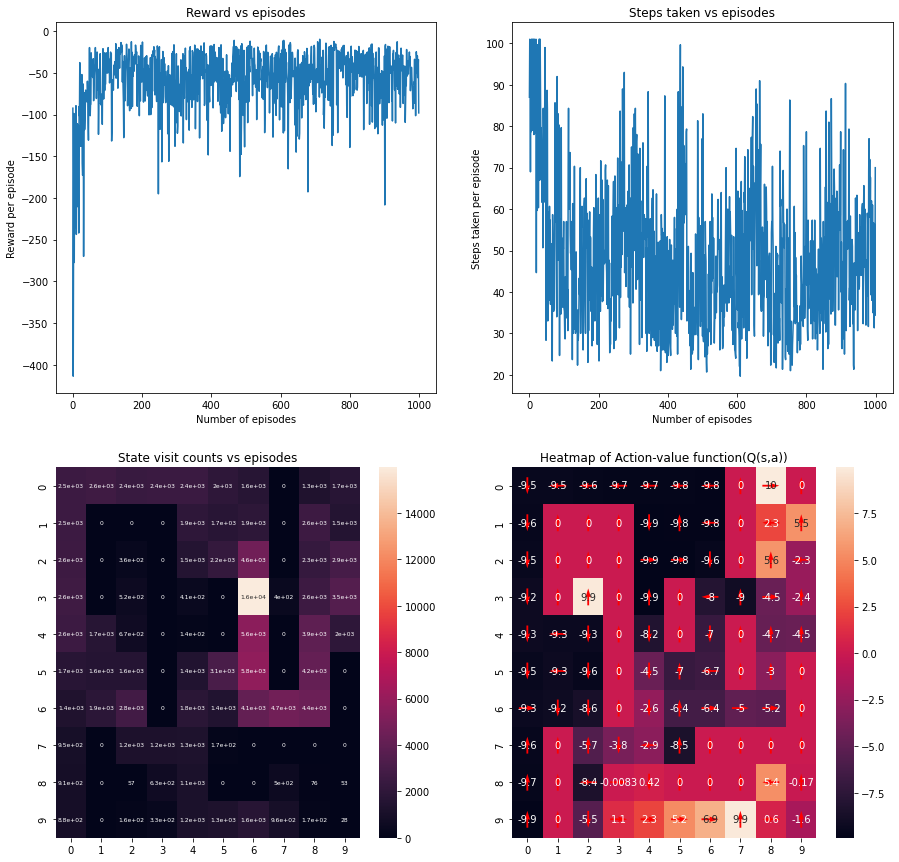

[[0.7, False, [[3, 6]], <function epsilon_greedy at 0x7f7e8c1b30d0>], 0.5, 0.9, 0.9, -11.0] -11.0
Current config:  14
Probability of good transition:  0.7  Wind:  False  Start state:  [[3, 6]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   0.1 0.9 0.1


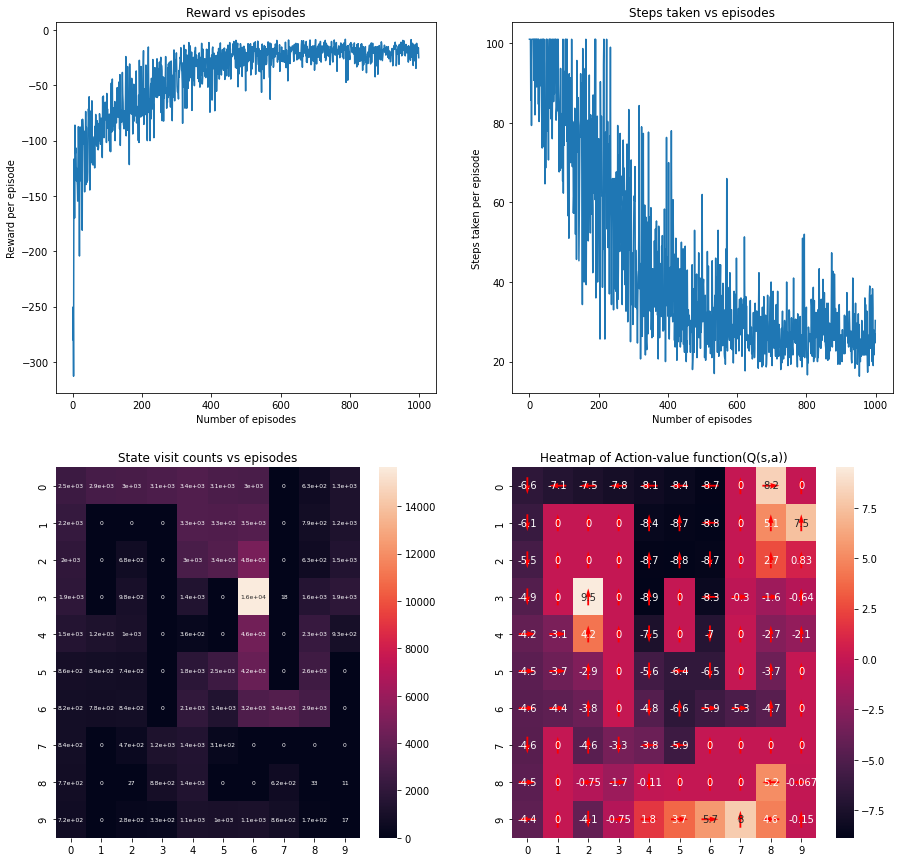

[[0.7, False, [[3, 6]], <function softmax at 0x7f7e8c1b3280>], 0.1, 0.9, 0.1, -8.333333333333334] -8.333333333333334
Current config:  15
Probability of good transition:  0.7  Wind:  False  Start state:  [[0, 4]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.1 0.5 0.5


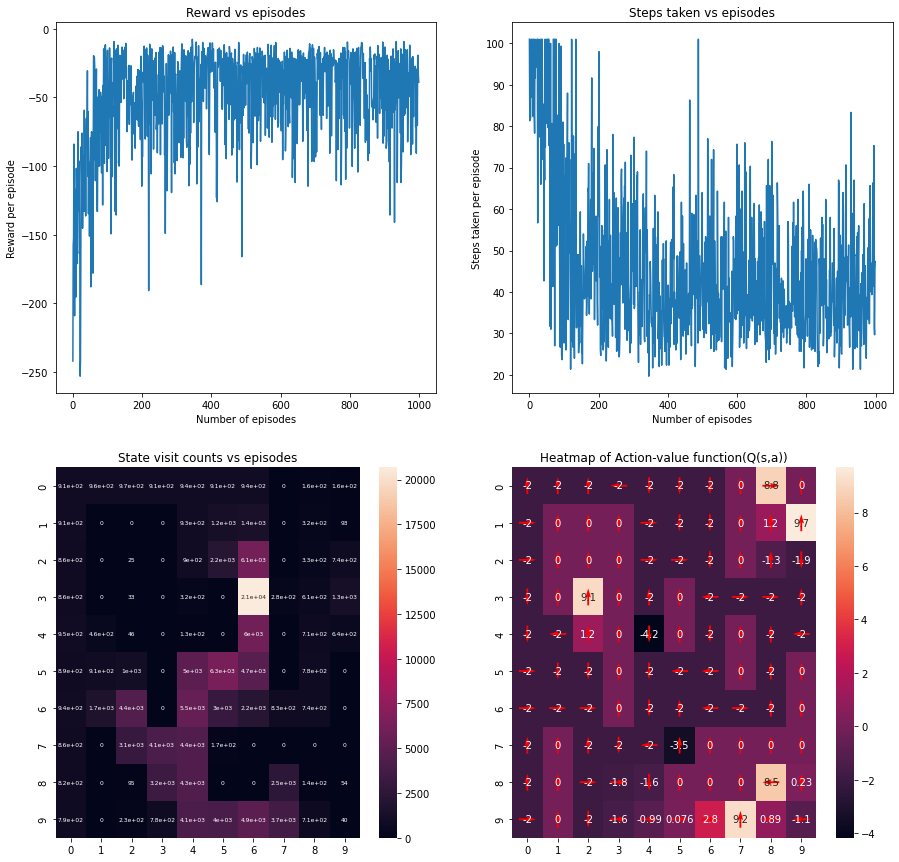

[[0.7, False, [[0, 4]], <function epsilon_greedy at 0x7f7e8c1b30d0>], 0.1, 0.5, 0.5, -12.0] -12.0
Current config:  16
Probability of good transition:  0.7  Wind:  False  Start state:  [[0, 4]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   0.1 0.9 0.9


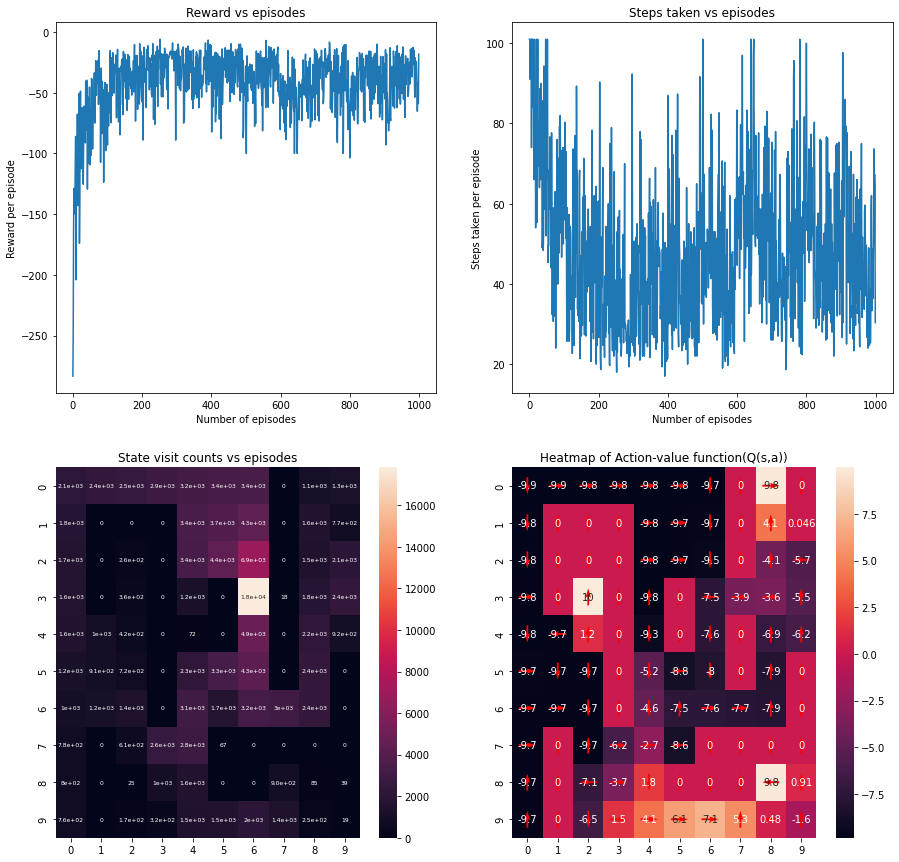

[[0.7, False, [[0, 4]], <function softmax at 0x7f7e8c1b3280>], 0.1, 0.9, 0.9, -9.333333333333334] -9.333333333333334


In [ ]:
#Hyperparameter tuning set 1

eps_vals   = [0.1, 0.5, 0.9]
beta_vals  = [0.1, 1, 10]
gamma_vals = [0.1, 0.5, 0.9]
alpha_vals = [0.1, 0.5, 0.9]

config_params = []
config_num    = 0
for p in [1,0.7]:
  for wind in [True, False]:
    for start_state in [[[3,6]], [[0,4]]]:
      for explore_strategy in [epsilon_greedy,softmax]:
        max_reward = -np.inf
        best_hyperparams = []
        config_num += 1
        print('Current config: ', config_num)
        Q = np.zeros((env.num_states, env.num_actions))
        current_config = [p,wind,start_state,explore_strategy]
        env.p_good_trans = p
        env.wind = wind
        env.start_state = start_state
        if explore_strategy == epsilon_greedy:
          for epsilon in eps_vals:
            for gamma in gamma_vals:
              for alpha in alpha_vals:

                Q_star,reward_avgs,steps_avgs,state_visit_count = run_simulation(Q,env,gamma,alpha,epsilon=epsilon,num_expts = 3, num_episodes = 1000,explore_strategy = epsilon_greedy)
                reward = cal_reward_Q(Q_star,env)
                
                if reward > max_reward:
                  max_reward = reward
                  best_hyperparams = [current_config,epsilon,gamma,alpha,reward]
          
          


        if explore_strategy == softmax:
          for beta in beta_vals:
            for gamma in gamma_vals:
              for alpha in alpha_vals:
                Q_star,reward_avgs,steps_avgs,state_visit_count = run_simulation(Q,env,gamma,alpha,beta=beta,num_expts = 3, num_episodes = 1000,explore_strategy = softmax )
                reward = cal_reward_Q(Q_star,env)
                if reward > max_reward:
                  max_reward = reward
                  best_hyperparams = [current_config,beta,gamma,alpha,reward]
        
        config_params.append(best_hyperparams)
        plot_figures(best_hyperparams,env,config_num)            
        print(best_hyperparams,max_reward)

Current config:  1


<ipython-input-7-7b0dfdf61705>:23: RuntimeWarning: overflow encountered in multiply
  Q[curr_state,curr_action] += alpha*(reward + (gamma*max(Q[next_state])) - Q[curr_state,curr_action])
<ipython-input-7-7b0dfdf61705>:23: RuntimeWarning: invalid value encountered in add
  Q[curr_state,curr_action] += alpha*(reward + (gamma*max(Q[next_state])) - Q[curr_state,curr_action])
<ipython-input-7-7b0dfdf61705>:23: RuntimeWarning: invalid value encountered in subtract
  Q[curr_state,curr_action] += alpha*(reward + (gamma*max(Q[next_state])) - Q[curr_state,curr_action])


Probability of good transition:  1  Wind:  True  Start state:  [[3, 6]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.7 0.8 1


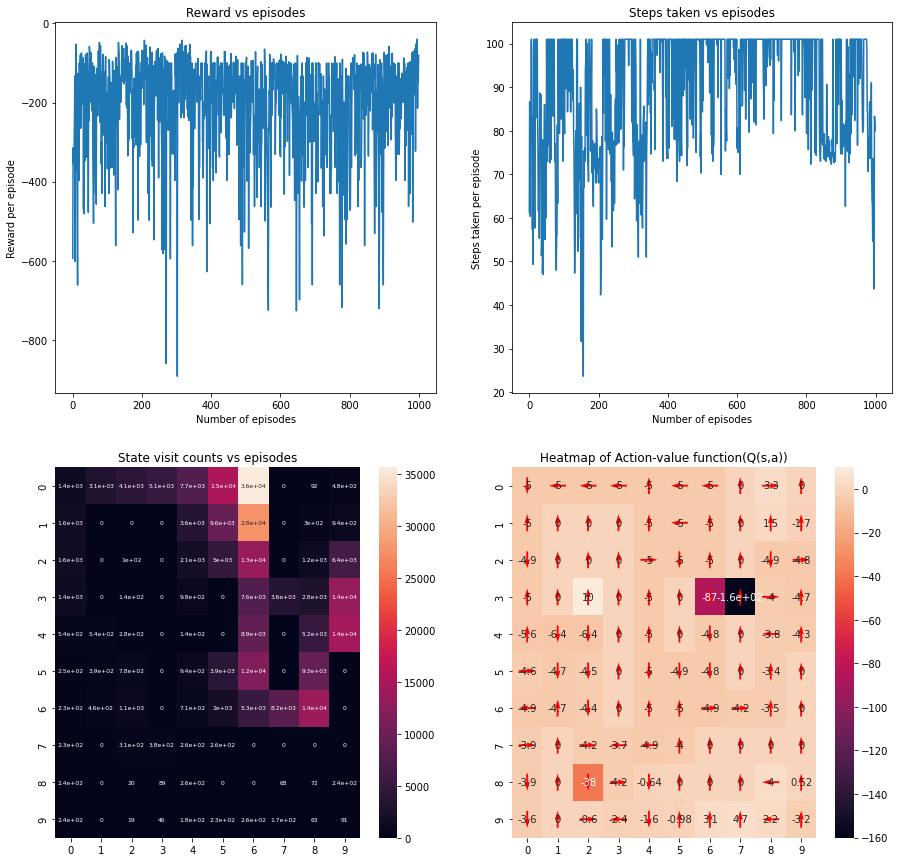

[[1, True, [[3, 6]], <function epsilon_greedy at 0x7f7c1abe6790>], 0.7, 0.8, 1, -34.333333333333336] -34.333333333333336
Current config:  2
Probability of good transition:  1  Wind:  True  Start state:  [[3, 6]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   50 0.8 0.7


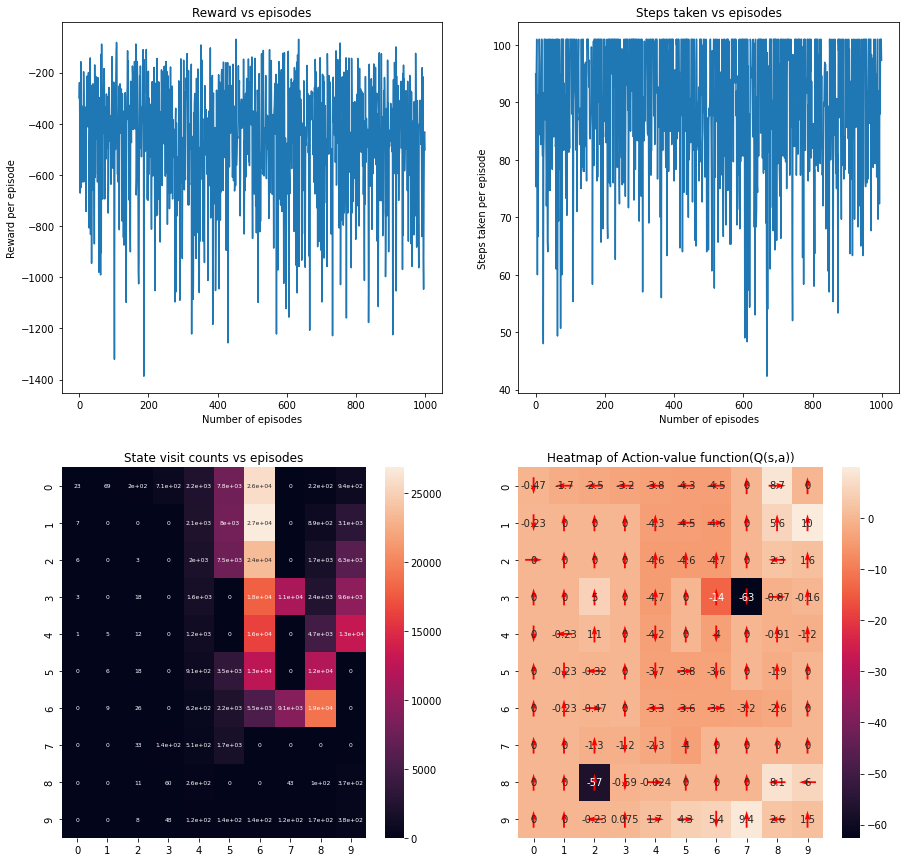

[[1, True, [[3, 6]], <function softmax at 0x7f7c1817a1f0>], 50, 0.8, 0.7, -20.0] -20.0
Current config:  3


<ipython-input-7-7b0dfdf61705>:23: RuntimeWarning: overflow encountered in add
  Q[curr_state,curr_action] += alpha*(reward + (gamma*max(Q[next_state])) - Q[curr_state,curr_action])


Probability of good transition:  1  Wind:  True  Start state:  [[0, 4]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.7 0.8 1


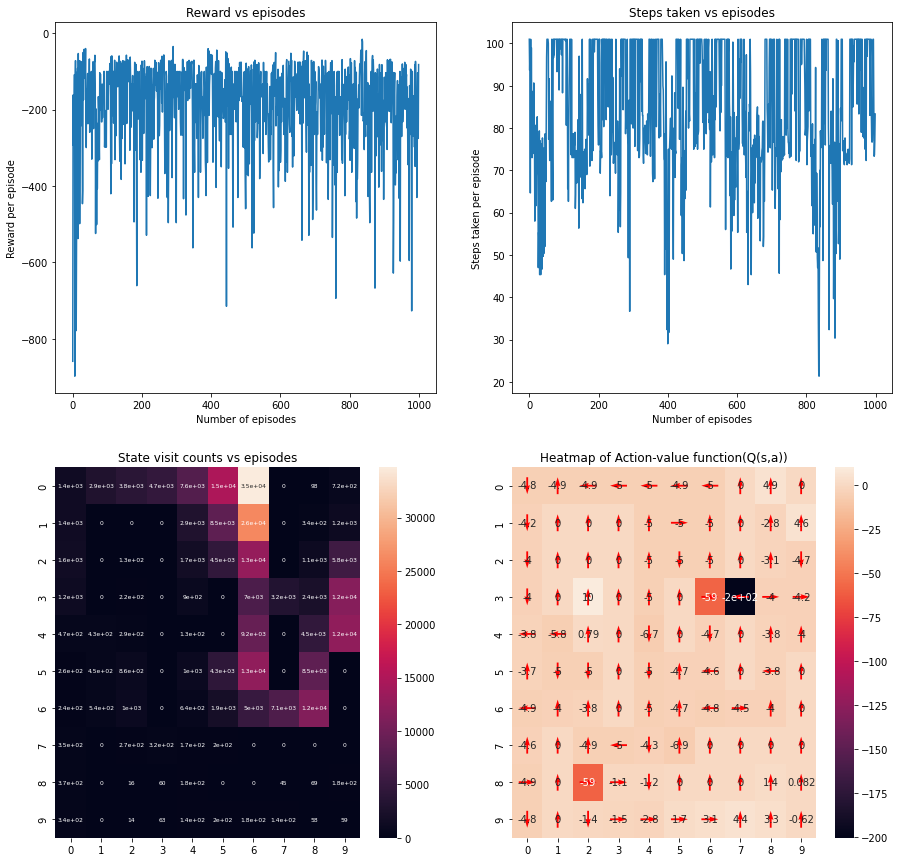

[[1, True, [[0, 4]], <function epsilon_greedy at 0x7f7c1abe6790>], 0.7, 0.8, 1, -7.666666666666667] -7.666666666666667
Current config:  4
Probability of good transition:  1  Wind:  True  Start state:  [[0, 4]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   5 0.8 1


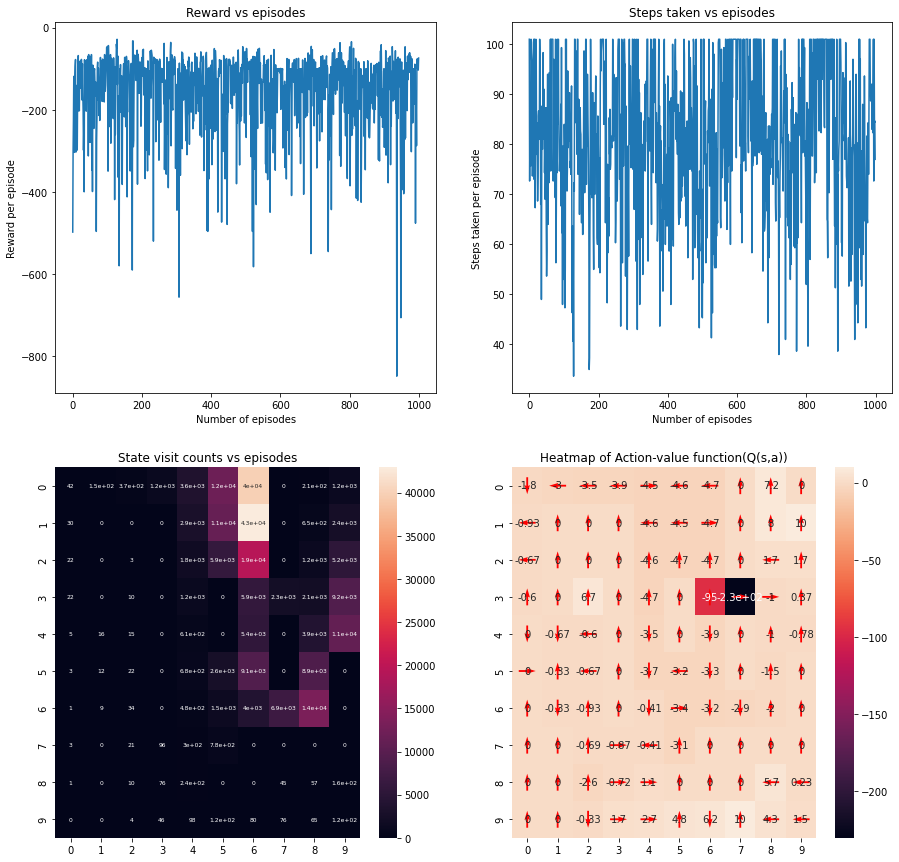

[[1, True, [[0, 4]], <function softmax at 0x7f7c1817a1f0>], 5, 0.8, 1, -12.0] -12.0
Current config:  5
Probability of good transition:  1  Wind:  False  Start state:  [[3, 6]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.3 0.8 0.7


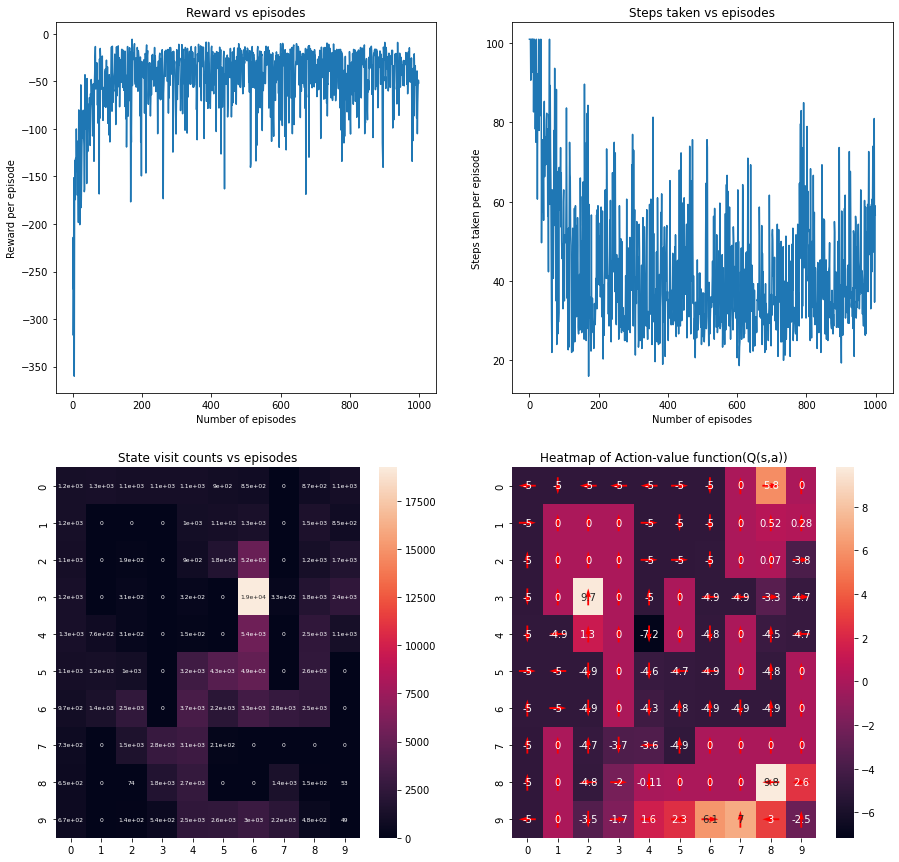

[[1, False, [[3, 6]], <function epsilon_greedy at 0x7f7c1abe6790>], 0.3, 0.8, 0.7, -11.333333333333334] -11.333333333333334
Current config:  6
Probability of good transition:  1  Wind:  False  Start state:  [[3, 6]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   50 0.6 0.7


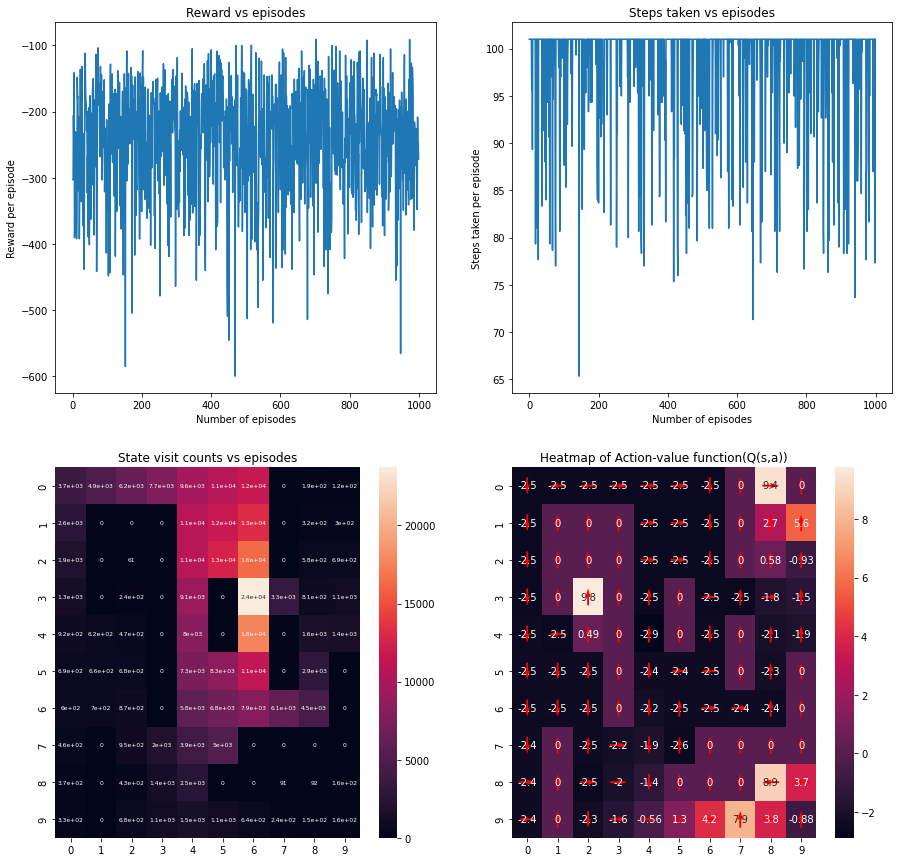

[[1, False, [[3, 6]], <function softmax at 0x7f7c1817a1f0>], 50, 0.6, 0.7, -18.666666666666668] -18.666666666666668
Current config:  7
Probability of good transition:  1  Wind:  False  Start state:  [[0, 4]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.3 0.6 0.7


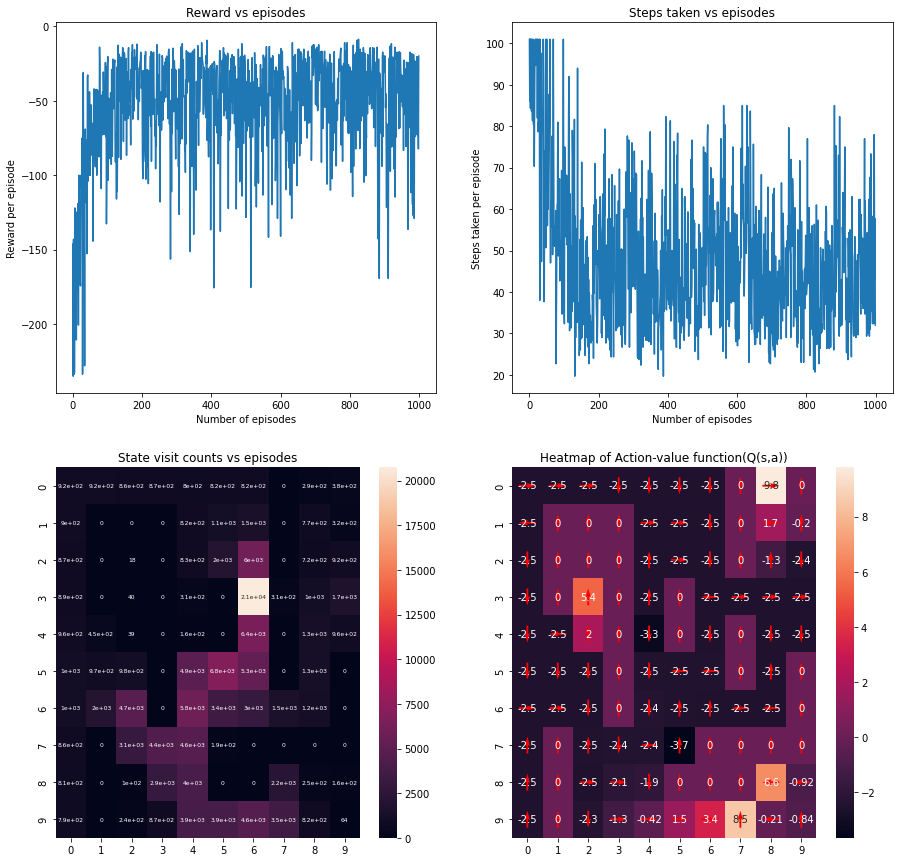

[[1, False, [[0, 4]], <function epsilon_greedy at 0x7f7c1abe6790>], 0.3, 0.6, 0.7, -11.333333333333334] -11.333333333333334
Current config:  8
Probability of good transition:  1  Wind:  False  Start state:  [[0, 4]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   5 0.6 0.7


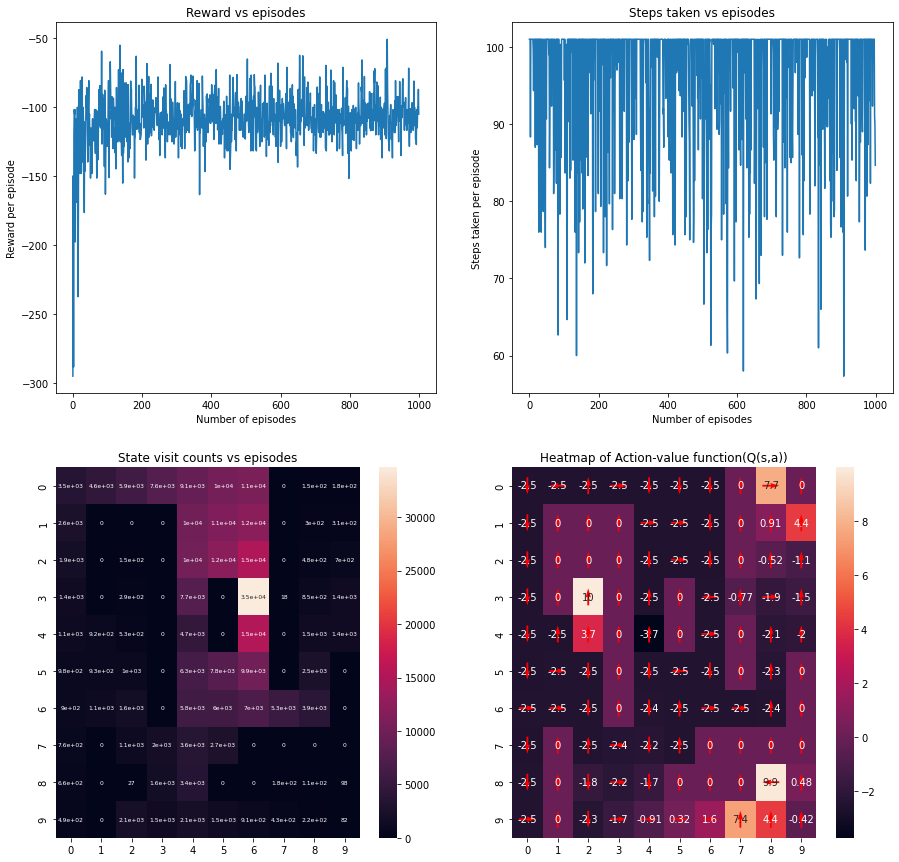

[[1, False, [[0, 4]], <function softmax at 0x7f7c1817a1f0>], 5, 0.6, 0.7, -17.666666666666668] -17.666666666666668
Current config:  9
Probability of good transition:  0.7  Wind:  True  Start state:  [[3, 6]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.7 0.8 0.7


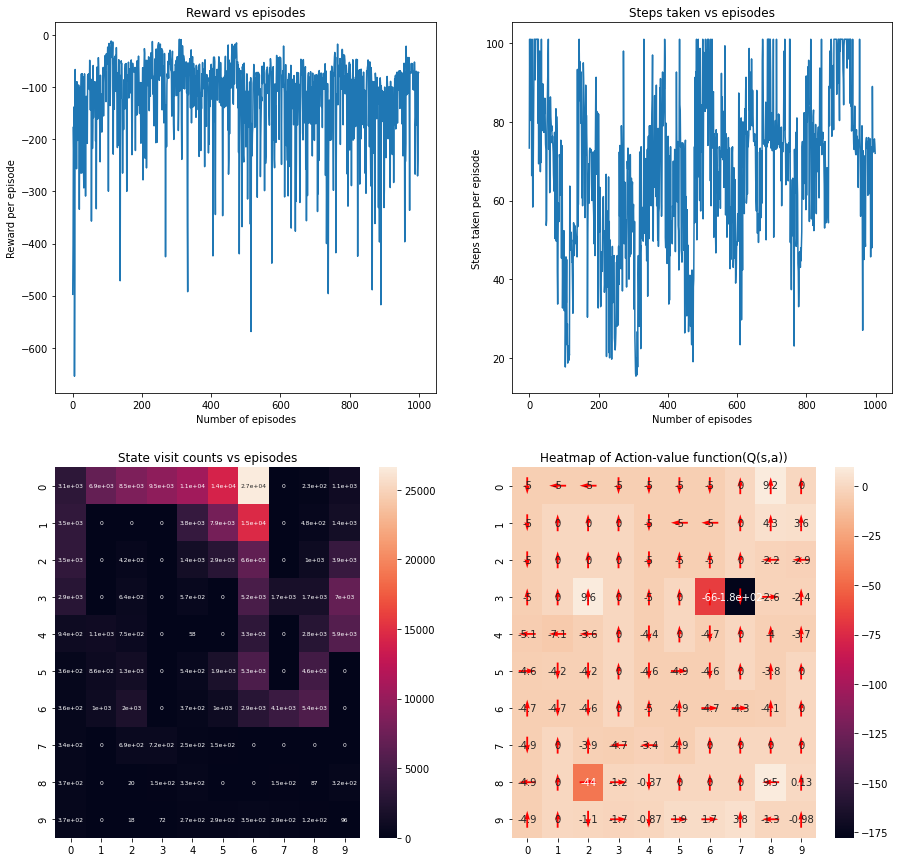

[[0.7, True, [[3, 6]], <function epsilon_greedy at 0x7f7c1abe6790>], 0.7, 0.8, 0.7, -23.666666666666668] -23.666666666666668
Current config:  10
Probability of good transition:  0.7  Wind:  True  Start state:  [[3, 6]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   50 0.6 1


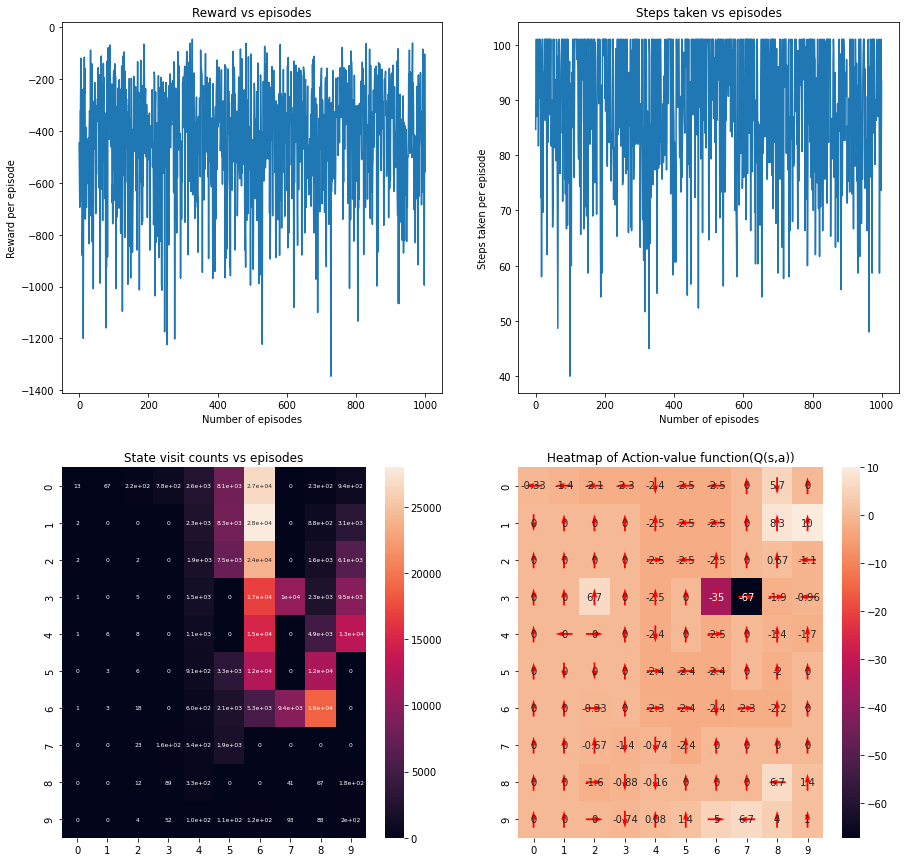

[[0.7, True, [[3, 6]], <function softmax at 0x7f7c1817a1f0>], 50, 0.6, 1, -20.333333333333332] -20.333333333333332
Current config:  11
Probability of good transition:  0.7  Wind:  True  Start state:  [[0, 4]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.7 0.8 0.7


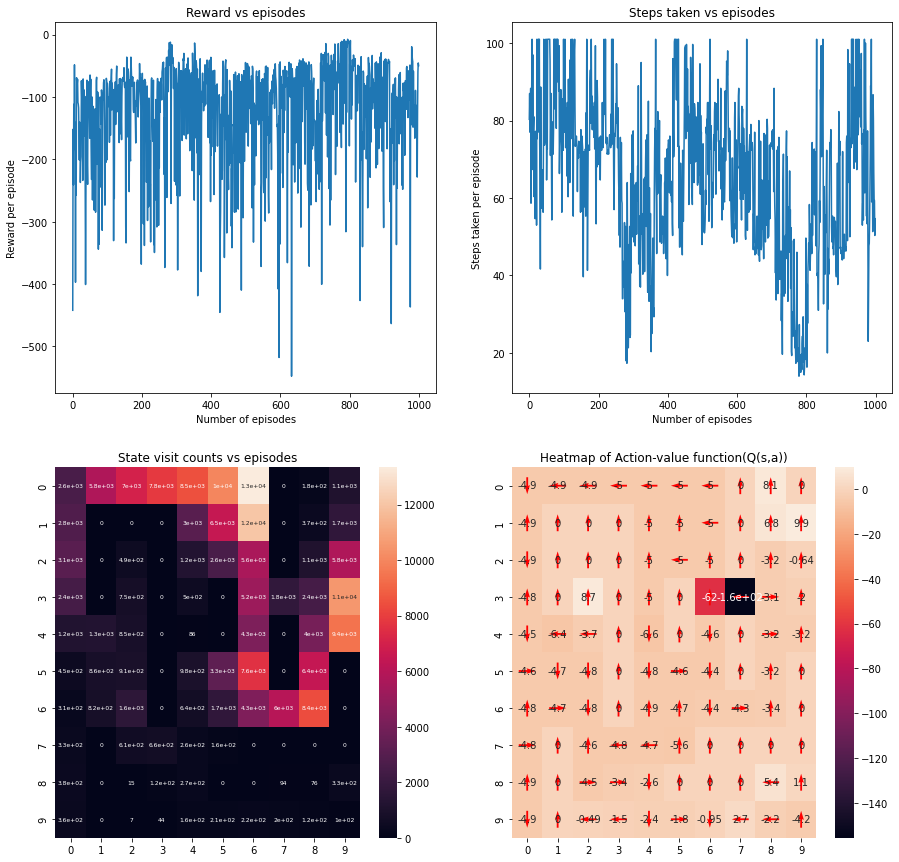

[[0.7, True, [[0, 4]], <function epsilon_greedy at 0x7f7c1abe6790>], 0.7, 0.8, 0.7, -9.666666666666666] -9.666666666666666
Current config:  12
Probability of good transition:  0.7  Wind:  True  Start state:  [[0, 4]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   5 0.6 0.7


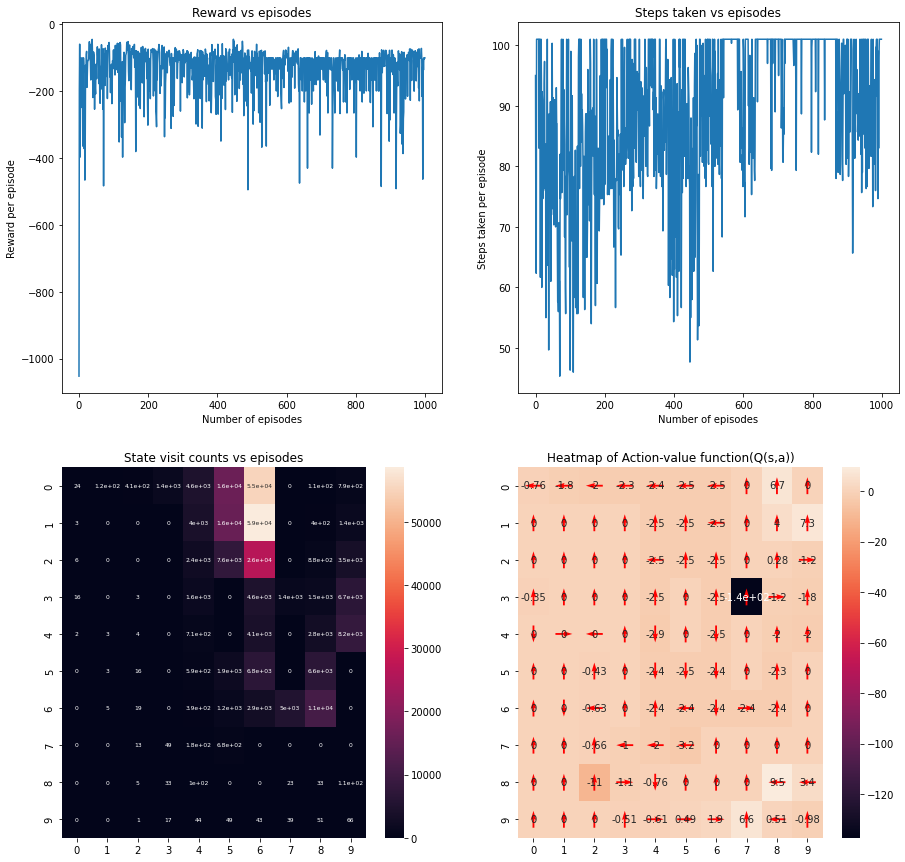

[[0.7, True, [[0, 4]], <function softmax at 0x7f7c1817a1f0>], 5, 0.6, 0.7, -29.0] -29.0
Current config:  13
Probability of good transition:  0.7  Wind:  False  Start state:  [[3, 6]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.3 0.8 0.7


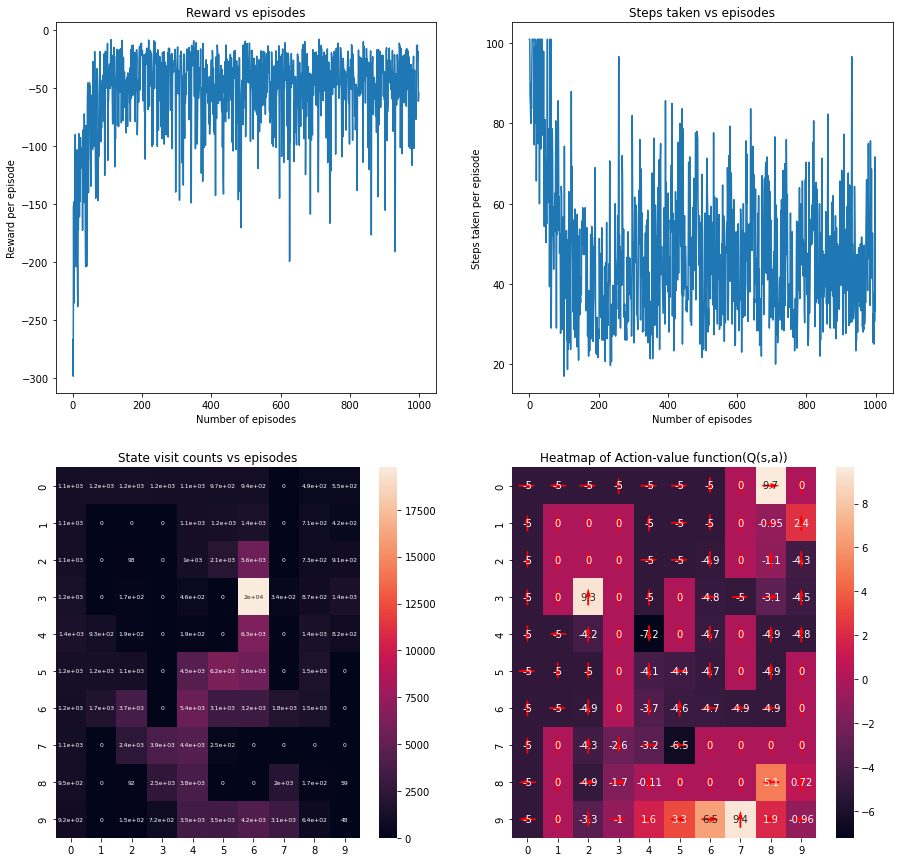

[[0.7, False, [[3, 6]], <function epsilon_greedy at 0x7f7c1abe6790>], 0.3, 0.8, 0.7, -14.333333333333334] -14.333333333333334
Current config:  14
Probability of good transition:  0.7  Wind:  False  Start state:  [[3, 6]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   50 0.3 0.7


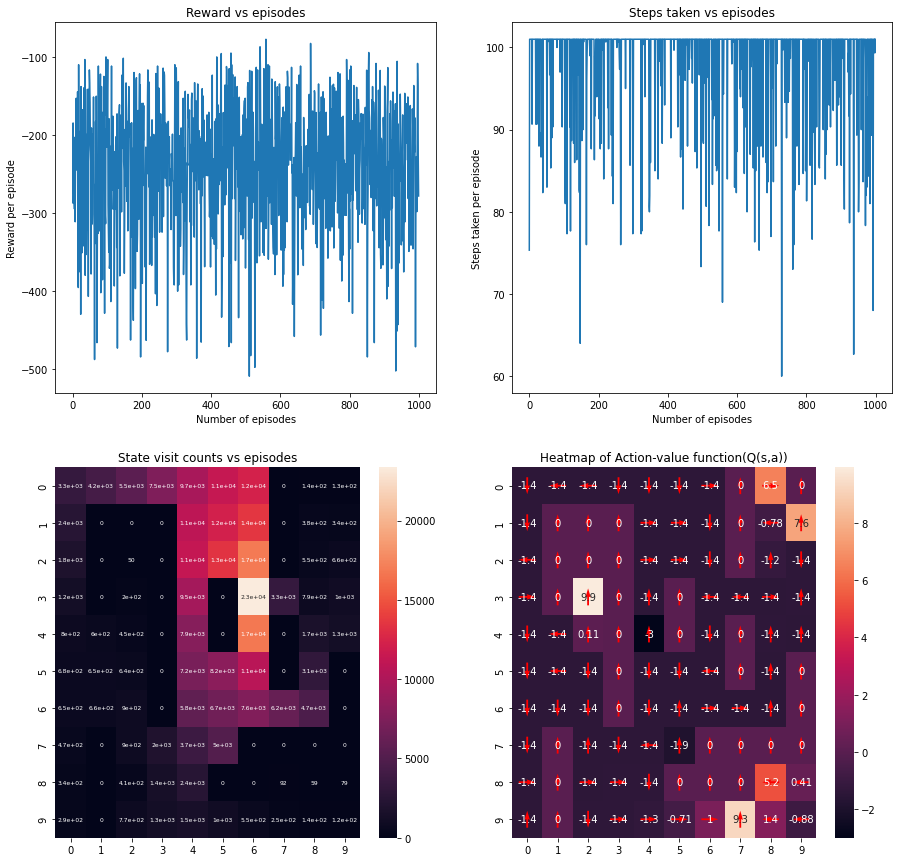

[[0.7, False, [[3, 6]], <function softmax at 0x7f7c1817a1f0>], 50, 0.3, 0.7, -18.666666666666668] -18.666666666666668
Current config:  15
Probability of good transition:  0.7  Wind:  False  Start state:  [[0, 4]]
Explore strategy: epsilon_greedy,  Best epsilon, gamma, alpha are :   0.99 0.3 0.7


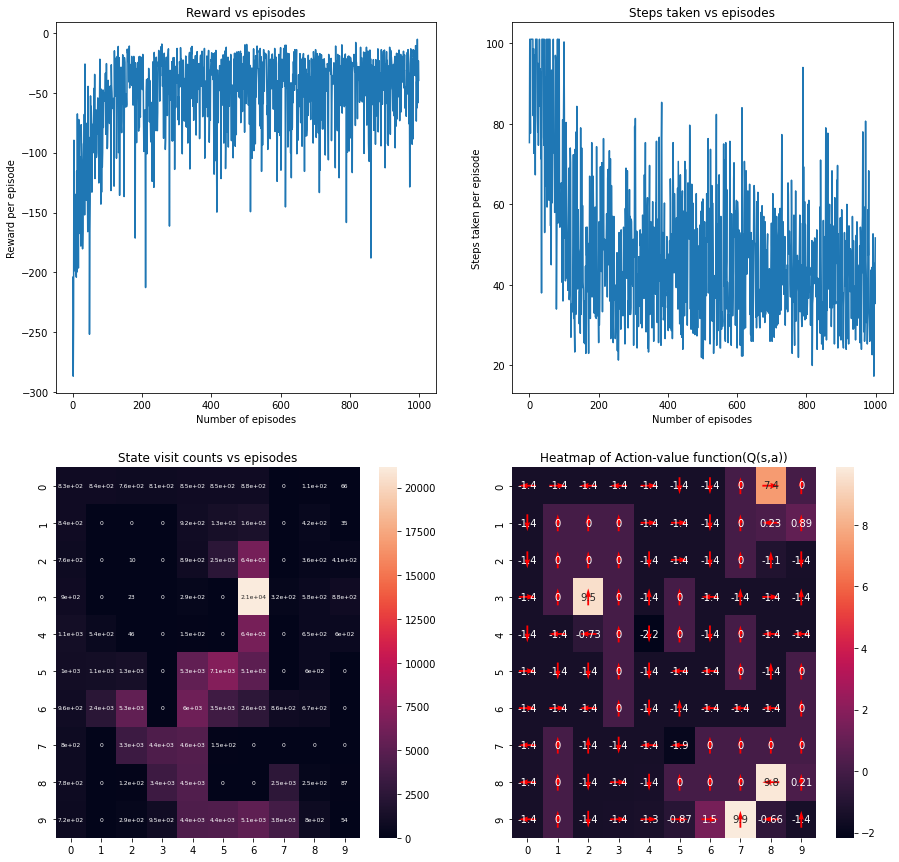

[[0.7, False, [[0, 4]], <function epsilon_greedy at 0x7f7c1abe6790>], 0.99, 0.3, 0.7, -12.0] -12.0
Current config:  16
Probability of good transition:  0.7  Wind:  False  Start state:  [[0, 4]]
Explore strategy: softmax,  Best beta, gamma, alpha are :   5 0.3 1


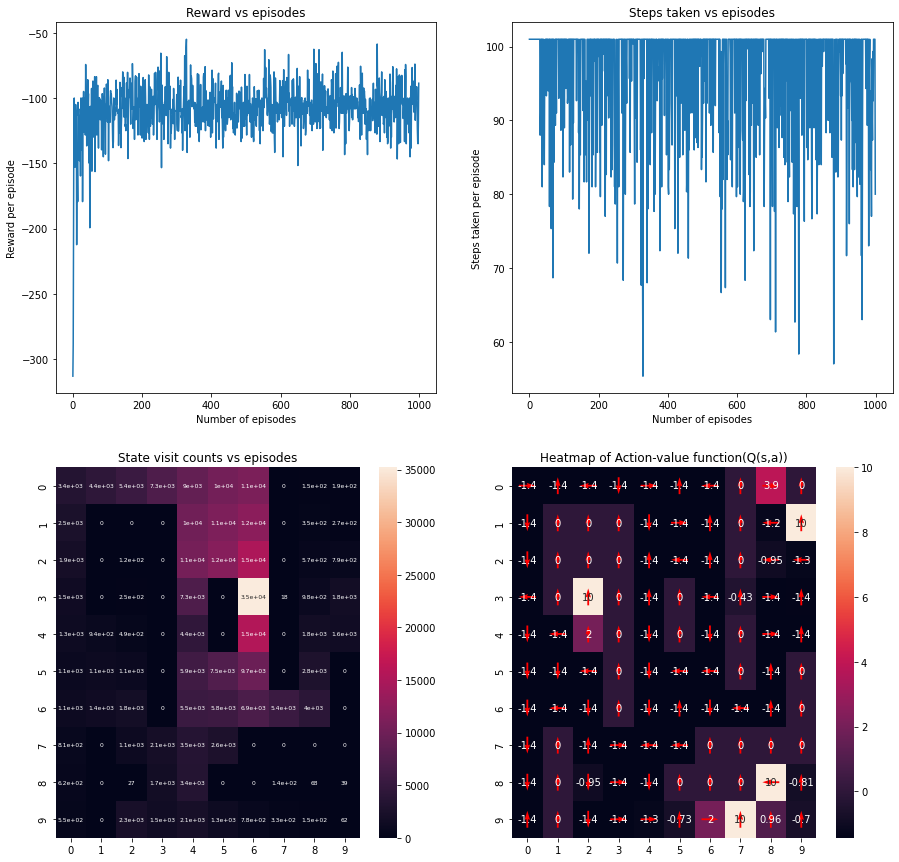

[[0.7, False, [[0, 4]], <function softmax at 0x7f7c1817a1f0>], 5, 0.3, 1, -17.666666666666668] -17.666666666666668


In [ ]:
#Hyperparameter tuning set 2

eps_vals   = [0.3, 0.7, 0.99]
beta_vals  = [0.05, 5, 50]
gamma_vals = [0.3, 0.6, 0.8]
alpha_vals = [0.7, 1, 2]
config_params = []
config_num    = 0
for p in [1,0.7]:
  for wind in [True, False]:
    for start_state in [[[3,6]], [[0,4]]]:
      for explore_strategy in [epsilon_greedy,softmax]:
        max_reward = -np.inf
        best_hyperparams = []
        config_num += 1
        print('Current config: ', config_num)
        Q = np.zeros((env.num_states, env.num_actions))
        current_config = [p,wind,start_state,explore_strategy]
        
        env.p_good_trans = p
        env.wind = wind
        env.start_state = start_state
        if explore_strategy == epsilon_greedy:
          for epsilon in eps_vals:
            for gamma in gamma_vals:
              for alpha in alpha_vals:
                try:
                  Q_star,reward_avgs,steps_avgs,state_visit_count = run_simulation(Q,env,gamma,alpha,epsilon=epsilon,num_expts = 3, num_episodes = 1000,explore_strategy = epsilon_greedy)
                  reward = cal_reward_Q(Q_star,env,repeat = 3)
                  
                  if reward > max_reward:
                    max_reward = reward
                    best_hyperparams = [current_config,epsilon,gamma,alpha,reward]
                except:
                  continue
          
          


        if explore_strategy == softmax:
          for beta in beta_vals:
            for gamma in gamma_vals:
              for alpha in alpha_vals:
                try:
                  Q_star,reward_avgs,steps_avgs,state_visit_count = run_simulation(Q,env,gamma,alpha,beta=beta,num_expts = 3, num_episodes = 1000,explore_strategy = softmax )
                  reward = cal_reward_Q(Q_star,env,repeat = 3)
                  if reward > max_reward:
                    max_reward = reward
                    best_hyperparams = [current_config,beta,gamma,alpha,reward]
                except:
                  continue
        
        config_params.append(best_hyperparams) 
        plot_figures(best_hyperparams,env,config_num)           
        print(best_hyperparams, max_reward)